### Script purpose

- Replicate and compare with: Anastasopoulos, L. Jason, and Andrew B. Whitford. 2019. “Machine Learning for Public Administration Research, With Application to Organizational Reputation.” Journal of Public Administration Research and Theory 29 (3): 491–510. https://doi.org/10.1093/jopart/muy060.
- Use glove-twitter-100 as embedding layer.

In [1]:
# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

# obtain reproducible results
import numpy as np
import tensorflow as tf
import random as rn
from keras import backend as K

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(520)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(520)
# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(520)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
# Rest of code follows ...

# Check GPU and CPU device.
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.




['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
#https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#RNN

import os
import pandas as pd
import re
from tqdm import tqdm
from multiprocessing import Pool
from spellchecker import SpellChecker
import string
import math

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
import matplotlib.pyplot as plt

# Plot using Plotly.
import plotly.express as px
import plotly.graph_objects as go

# For encoding labels.
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [3]:
df_coded_tweet=pd.read_csv('../../dataset/muy060_suppl_supplementary_appendix/muy060_Appendix_2.csv')
df_coded_tweet.loc[df_coded_tweet.JasonCode==2, 'moral_bin']=1
df_coded_tweet.moral_bin.fillna('0', inplace=True)
df_coded_tweet['moral_bin']=[int(s) for s in df_coded_tweet.moral_bin]
df_coded_tweet.sample(5)

,HITID,Text,Answer1,Answer2,Agreement,Answer,Date,JasonCode,moral_bin
131,3S8APUMBJXJH52HB7544QEW4FM8FBI,Denver OCEDETF Strike Force Takes Down Mexican...,Moral Reputation,Technical Reputation,No,no_agreement,2018-07-06 18:04:11 UTC,1,0
30,302OLP89DZ75JGS9APE7NXRV0RVAC7,Dep Sec Raskin In our interconnected economy v...,Moral Reputation,Moral Reputation,Yes,Moral Reputation,2018-07-06 18:08:44 UTC,4,0
63,3UQVX1UPFSHWKL2PLUS8ME6WFE602X,RT dcpublicschools The work that you are doing...,Moral Reputation,Performative Reputation,No,no_agreement,2018-07-06 17:59:25 UTC,2,1
35,37OPIVELUU3W0O3PWHS8YOOBDJ0AHG,RT statedeptspox DepSec Sullivan with Latvias ...,Performative Reputation,Technical Reputation,No,no_agreement,2018-07-06 17:59:44 UTC,0,0
183,3P7QK0GJ3TLTM68FPO50SD9IXLP2ZR,Acting Secretary Duke met with security offici...,Moral Reputation,None of the above.,No,no_agreement,2018-07-06 18:19:43 UTC,1,0


In [4]:
df_agency_tweets_database=pd.read_csv('../../dataset/muy060_suppl_supplementary_appendix/muy060_Appendix_1.csv', encoding='ISO-8859-1')
df_agency_tweets_database.sample(3)

,agency_id,tweet_text,tweet_favorites,tweet_retweets,tweet_created
5605,USDOT,RT @fema: For a list of trusted accounts shari...,0,1152,1.504719e+09
18716,usedgov,RT @HispanicEd: We are also excited to announc...,0,22,1.476983e+09
18221,ENERGY,RT @BerkeleyLab: Chiral phonons to atoms: Letâ...,0,28,1.518022e+09


In [5]:
df_train, df_val=train_test_split(df_coded_tweet[['Text', 'moral_bin']], test_size=0.3, random_state=520)

In [6]:
text_token_list_train=df_train['Text']
text_token_list_val=df_val['Text']
text_token_list_pred=df_agency_tweets_database['tweet_text']

In [7]:
# Prepare labels
from sklearn import preprocessing
from keras.utils import to_categorical
lb = preprocessing.LabelBinarizer()

lb.fit(df_coded_tweet.moral_bin.unique())
y_train = to_categorical(lb.transform(df_train['moral_bin']))
y_val = to_categorical(lb.transform(df_val['moral_bin']))

In [8]:
# Build word index for train and validation texts.
tokenizer=Tokenizer()
text_list_total=df_coded_tweet['Text'].to_list()+df_agency_tweets_database['tweet_text'].to_list()
tokenizer.fit_on_texts(text_list_total) # Including uncoded tweets, vocabulary must be comprehensive.
print(list(tokenizer.word_index.items())[0:5])

[('https', 1), ('t', 2), ('co', 3), ('the', 4), ('to', 5)]


In [9]:
## Train dataset.
# Text to sequences.
seq_encoding_text_train=tokenizer.texts_to_sequences(text_token_list_train)
seq_encoding_text_val=tokenizer.texts_to_sequences(text_token_list_val)
seq_encoding_text_pred=tokenizer.texts_to_sequences(text_token_list_pred)
seq_encoding_text_all=seq_encoding_text_train+seq_encoding_text_val+seq_encoding_text_pred

# Pads sequences to the same length (i.e., prepare matrix).
x_train=pad_sequences(sequences=seq_encoding_text_train,
                      maxlen=max([len(s) for s in seq_encoding_text_all]), # Max length of the sequence. Must consider prediction dataset.
                      dtype = "int32", padding = "post", truncating = "post", 
                      value = 0 # Zero is used for representing None or Unknown.
                     )
x_val=pad_sequences(sequences=seq_encoding_text_val,
                    maxlen=max([len(s) for s in seq_encoding_text_all]), # Max length of the sequence. Must consider prediction dataset.
                    dtype = "int32", padding = "post", truncating = "post", 
                    value = 0 # Zero is used for representing None or Unknown.
                   )
x_pred=pad_sequences(sequences=seq_encoding_text_pred,
                     maxlen=max([len(s) for s in seq_encoding_text_all]), # Max length of the sequence. Must consider prediction dataset.
                     dtype = "int32", padding = "post", truncating = "post", 
                     value = 0 # Zero is used for representing None or Unknown.
                     )

In [10]:
import gensim.downloader as api
EMBEDDING_DIM=100
# glove_word_vector=api.load('glove-wiki-gigaword-'+str(EMBEDDING_DIM))
glove_word_vector=api.load('glove-twitter-'+str(EMBEDDING_DIM))

In [11]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, EMBEDDING_DIM)) # Plus one: embedding matrix starts from 0, word index starts from 1.

In [12]:
for word, index in tokenizer.word_index.items():
    try:
        embedding_matrix[index] = glove_word_vector.get_vector(word)
    except:
        pass
        # words not found in embedding index will be all-zeros.

In [13]:
input_length=len(x_train[0])
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, # Size of vocabulary.
                            input_length=input_length, # Length of input, i.e., length of padded sequence.
                            output_dim=EMBEDDING_DIM, # Size of the vector space in which words will be embedded.
                            weights=[embedding_matrix],
                            trainable=False)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPool1D, Conv1D
from datetime import datetime
import itertools

num_filters=[32, 64, 128]
kernel_size=[3,5,7]
conv_act=['sigmoid', 'softplus', 'tanh', 'softmax']
act_32=['sigmoid', 'softplus', 'tanh', 'softmax']
act_16=['sigmoid', 'softplus', 'tanh', 'softmax']
out_act=['sigmoid', 'softplus', 'tanh', 'softmax']
param_list=list(itertools.product(num_filters, kernel_size, conv_act, act_32, act_16, out_act))

In [15]:
result_list=[]

for num_filters, kernel_size, conv_act, act_32, act_16, out_act in tqdm(param_list):
    with tf.device('/CPU:0'): # Use CPU.
        model = Sequential()
        model.add(embedding_layer)
        # model.add(Flatten())
        model.add(Conv1D(num_filters, kernel_size, activation=conv_act))
        model.add(GlobalMaxPool1D())
        model.add(Dense(units=32, activation=act_32))
        model.add(Dense(units=16, activation=act_16))
        model.add(Dense(units=len(y_train[0]), activation=out_act))
        # compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
        # F1, precision, and recall removed. https://github.com/keras-team/keras/issues/5794
        # fit the model
        history=model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=100, verbose=0)
        result_list+=[[max(history.history['val_acc']), [num_filters, kernel_size, conv_act, act_32, act_16, out_act]]]
        ############### Clean up and rebuid objects; otherwise, tensor graph becomes larger and larger and requires more time. ##########
        del model
        K.clear_session() # Will cause error: Tensor must from the same graph. Cause: Embedding layers changed. Solution: rebuild embedding layer.
        ##### Initialize session for reproducibility #####
        np.random.seed(520)
        rn.seed(520)
        session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                                      inter_op_parallelism_threads=1)
        tf.set_random_seed(520)
        sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
        K.set_session(sess)
        ##################################################
        # Rebuid embedding layer.
        embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, # Size of vocabulary.
                                    input_length=input_length, # Length of input, i.e., length of padded sequence.
                                    output_dim=EMBEDDING_DIM, # Size of the vector space in which words will be embedded.
                                    weights=[embedding_matrix],
                                    trainable=False)
        #################################################################################################################################

  0%|          | 0/2304 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|██████████| 2304/2304 [2:53:56<00:00,  7.17s/it]  


In [16]:
pd.DataFrame(result_list).sort_values(0, ascending=False)[0:10]

,0,1
517,0.866667,"[32, 7, sigmoid, sigmoid, softplus, softplus]"
1897,0.866667,"[128, 5, softplus, tanh, tanh, softplus]"
1005,0.866667,"[64, 3, softmax, tanh, softmax, softplus]"
993,0.866667,"[64, 3, softmax, tanh, sigmoid, softplus]"
992,0.866667,"[64, 3, softmax, tanh, sigmoid, sigmoid]"
131,0.866667,"[32, 3, tanh, sigmoid, sigmoid, softmax]"
977,0.866667,"[64, 3, softmax, softplus, sigmoid, softplus]"
959,0.866667,"[64, 3, tanh, softmax, softmax, softmax]"
1001,0.866667,"[64, 3, softmax, tanh, tanh, softplus]"
2047,0.866667,"[128, 5, softmax, softmax, softmax, softmax]"


In [17]:
pd.DataFrame(result_list).sort_values(0, ascending=False).to_csv('../../output/muy060_grid_search_glove-tweet.tsv', sep='\t')

### Train final model

In [22]:
############### Clean up and rebuid objects; otherwise, tensor graph becomes larger and larger and requires more time. ##########
K.clear_session() # Will cause error: Tensor must from the same graph. Cause: Embedding layers changed. Solution: rebuild embedding layer.
##### Initialize session for reproducibility #####
np.random.seed(520)
rn.seed(520)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.set_random_seed(520)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
##################################################
# Rebuid embedding layer.
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, # Size of vocabulary.
                            input_length=input_length, # Length of input, i.e., length of padded sequence.
                            output_dim=EMBEDDING_DIM, # Size of the vector space in which words will be embedded.
                            weights=[embedding_matrix],
                            trainable=False)
#################################################################################################################################
with tf.device('/CPU:0'):
    model = Sequential()
    model.add(embedding_layer)
    # model.add(Flatten())
    model.add(Conv1D(32, 7, activation='sigmoid'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(units=32, activation='sigmoid'))
    model.add(Dense(units=16, activation='softplus'))
    model.add(Dense(units=len(y_train[0]), activation='softplus'))
    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    # F1, precision, and recall removed. https://github.com/keras-team/keras/issues/5794
    # fit the model
    history=model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=36, verbose=0)
    print(max(history.history['val_acc']))

0.8666666746139526


### Verify performance measures.

In [27]:
from sklearn.metrics import precision_recall_fscore_support
y_val_pred=lb.inverse_transform(np_utils.to_categorical(model.predict(x_val).argmax(axis=-1))).tolist()
precision_recall_fscore_support(y_true=lb.inverse_transform(y_val), y_pred=y_val_pred)

(array([0.89189189, 0.82608696]),
 array([0.89189189, 0.82608696]),
 array([0.89189189, 0.82608696]),
 array([37, 23]))

In [50]:
df_score.groupby('true').count()

,pred
true,
0,37
1,23


In [74]:
df_score=pd.concat([pd.Series(lb.inverse_transform(y_val)), pd.Series(y_val_pred)], axis=1).rename(columns={0:'true', 1:'pred'})
# Accuracy.
print(len(df_score[df_score.true==df_score.pred])/len(df_score))
# Precision: tp/(tp+fp)
tp=len(df_score[(df_score.true==1)&(df_score.pred==1)])
fp=len(df_score[(df_score.true==0)&(df_score.pred==1)])
tp/(tp+fp)

0.8666666666666667


0.8260869565217391

In [55]:
# Recall: tp / (tp + fn)
fn=len(df_score[(df_score.true==1)&(df_score.pred==0)])
tp/(tp+fn)

0.8260869565217391

In [56]:
tn=len(df_score[(df_score.true==0)&(df_score.pred==0)])
print(tp, tn, fp, fn)

19 33 4 4


### Predict uncoded data.

In [80]:
y_prob=model.predict(x_pred)
y_pred=lb.inverse_transform(np_utils.to_categorical(y_prob.argmax(axis=-1))).tolist()

df_agency_tweets_database['moral_pred']=y_pred
df_moral_stats=df_agency_tweets_database.groupby('agency_id').count()[['tweet_text']].merge(df_agency_tweets_database.groupby('agency_id').sum()[['moral_pred']], left_index=True, right_index=True, how='left')
df_moral_stats['moral_ptg']=df_moral_stats['moral_pred']/df_moral_stats['tweet_text']
df_moral_stats['ci_95']=np.sqrt(df_moral_stats.moral_ptg*(1-df_moral_stats.moral_ptg)/df_moral_stats.tweet_text)*1.96
df_moral_stats.sort_values('moral_ptg', ascending=False, inplace=True)
df_moral_stats.reset_index(inplace=True)
df_moral_stats

,agency_id,tweet_text,moral_pred,moral_ptg,ci_95
0,DeptVetAffairs,1968,1256,0.638211,0.021230
1,usedgov,1927,1012,0.525169,0.022296
2,HHSGov,1988,997,0.501509,0.021979
3,Interior,1031,502,0.486906,0.030510
4,DeptofDefense,1898,764,0.402529,0.022063
5,HUDgov,1870,714,0.381818,0.022020
6,USDA,1996,642,0.321643,0.020492
7,DHSgov,1975,565,0.286076,0.019931
8,StateDept,1988,468,0.235412,0.018650
9,USDOT,1953,459,0.235023,0.018805


In [81]:
df_moral_stats['agency_id'].replace(dict(DeptVetAffairs='DeptVetAffairs(0)',
                                         usedgov='usedgov(0)',
                                         HHSGov='HHSGov(0)',
                                         Interior='Interior(+6)',
                                         DeptofDefense='DeptofDefense(+6)',
                                         HUDgov='HUDgov(-2)',
                                         USDA='USDA(0)',
                                         DHSgov='DHSgov(-2)',
                                         StateDept='StateDept(+4)',
                                         USDOT='USDOT(-2)',
                                         CommerceGov='CommerceGov(-2)',
                                         ENERGY='ENERGY(-7)',
                                         USTreasury='USTreasury(-1)',
                                         TheJusticeDept='TheJusticeDept(0)'
                                        ), inplace=True)

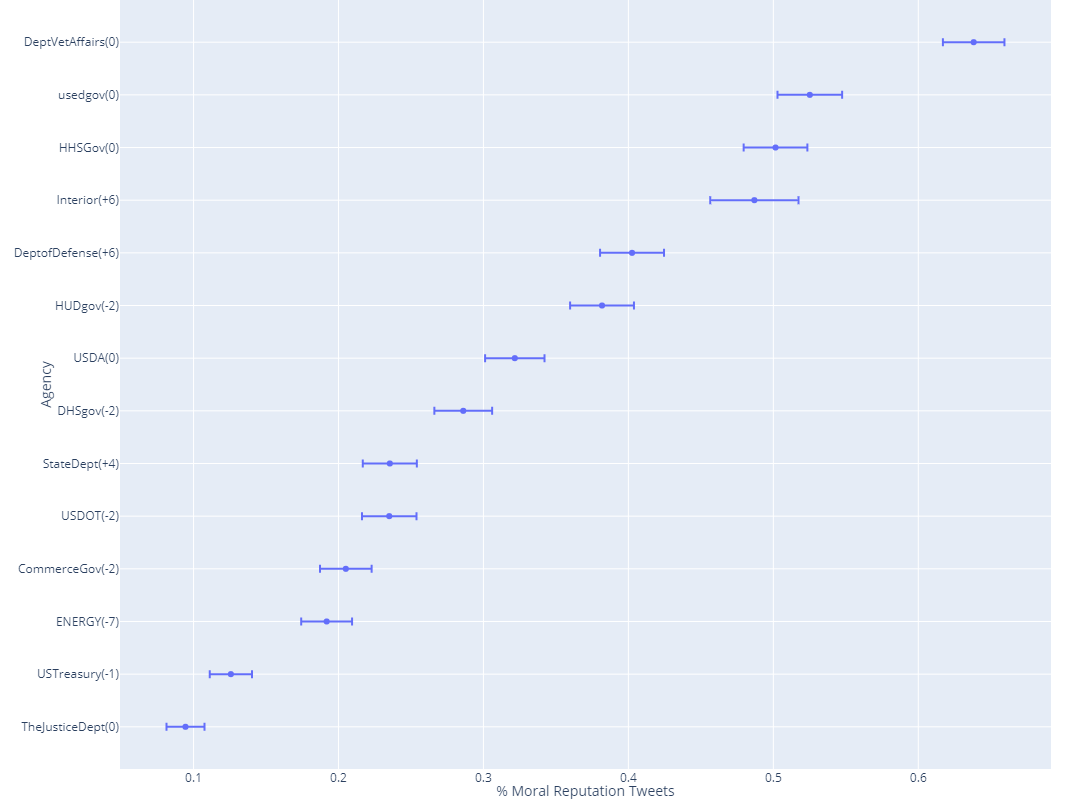

In [82]:
fig=px.scatter(df_moral_stats.reset_index().sort_values('moral_ptg'), x='moral_ptg', y='agency_id', error_x='ci_95',
               labels=dict(agency_id='Agency', moral_ptg='% Moral Reputation Tweets')
              )
fig.update_layout(width=600, height=800,
                  margin={'t': 0, 'b': 15, 'r':0, 'l':0},
                 )
fig.show()
fig.write_image('../../output/fig/muy060_replicate.pdf')

In [83]:
# Build word index for train and validation texts.
tokenizer_coded=Tokenizer()
tokenizer_coded.fit_on_texts(df_coded_tweet['Text'].to_list())
tokenizer_raw=Tokenizer()
tokenizer_raw.fit_on_texts(df_agency_tweets_database['tweet_text'].to_list())
print(len(tokenizer_coded.word_index.items()), len(tokenizer_raw.word_index.items()))

1830 53594


In [92]:
len([s for s in tokenizer_coded.word_index.keys() if 'http' not in s]), len([s for s in tokenizer_coded.word_index.keys() if s not in tokenizer_raw.word_index.keys() and 'http' not in s])

(1672, 67)

In [93]:
len([s for s in tokenizer_raw.word_index.keys() if 'http' not in s]), len([s for s in tokenizer_raw.word_index.keys() if s not in tokenizer_coded.word_index.keys() and 'http' not in s])

(53544, 51939)

## Traps.

- Tried GridSearchCV, suffers from the "tensor graph becomes larger and larger" problem.

<s>
    
```Python
def create_model(num_filters, kernel_size, conv_act, act_first, act_second, out_act):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation=conv_act))
    model.add(GlobalMaxPool1D())
    model.add(Dense(units=32, activation=act_first))
    model.add(Dense(units=16, activation=act_second))
    model.add(Dense(units=len(y_train[0]), activation=out_act))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
neural_network = KerasClassifier(build_fn=create_model, validation_split=0.3, verbose=0)
grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters)
grid_result = grid.fit(x_train, y_train, verbose=1)
```
    
</s>

- Give up trying multiprocessing: fail to send embedding layer (a pickle object) to threads.
    - possible solution: buid embedding layer on remote engines/threads.
        - Tried, looks like not working. Since it now only takes about 1.5 hours to complete the job, give up, move on.

<s>

```Python
import ipyparallel as ipp
c = ipp.Client()
print(c.ids)
dview = c[:]

dview['Sequential']=Sequential
dview['embedding_layer']=embedding_layer
dview['Conv1D']=Conv1D
dview['GlobalMaxPool1D']=GlobalMaxPool1D
dview['Dense']=Dense

@dview.parallel(block=True)
def grid_search(params):
    model = Sequential()
    model.add(embedding_layer)
    # model.add(Flatten())
    model.add(Conv1D(params[0], params[1], activation=params[2]))
    model.add(GlobalMaxPool1D())
    model.add(Dense(units=32, activation=params[3]))
    model.add(Dense(units=16, activation=params[4]))
    model.add(Dense(units=len(y_train[0]), activation=params[5]))
    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    # F1, precision, and recall removed. https://github.com/keras-team/keras/issues/5794
    # fit the model
    history=model.fit(x_train, y_train, validation_split=0.3, epochs=100, verbose=0)
    return [[max(history.history['val_acc']), [num_filters, kernel_size, conv_act, act_32, act_16, out_act]]]

grid_search.map(param_list)

def grid_search(params):
    with tf.device('/gpu:0'): # Specify which GPU to use.
        model = Sequential()
        model.add(embedding_layer)
        # model.add(Flatten())
        model.add(Conv1D(params[0], params[1], activation=params[2]))
        model.add(GlobalMaxPool1D())
        model.add(Dense(units=32, activation=params[3]))
        model.add(Dense(units=16, activation=params[4]))
        model.add(Dense(units=len(y_train[0]), activation=params[5]))
        # compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
        # F1, precision, and recall removed. https://github.com/keras-team/keras/issues/5794
        # fit the model
        history=model.fit(x_train, y_train, validation_split=0.3, epochs=100, verbose=0)
    return [[max(history.history['val_acc']), [num_filters, kernel_size, conv_act, act_32, act_16, out_act]]]

from multiprocessing import Pool
# if __name__== "__main__":
p=Pool(10)
result_list=p.map(grid_search, param_list)
```

</s>